In [368]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline
NUM_CLASSES = 27*28
T = torch.tensor

CONTEXT_LEN = 3
FEATURE_DIM = 10
HIDDEN_LAYER_SIZE = 200
BATCH_SIZE = 1000
PER_BATCH_LOOP_COUNT = 1

In [369]:
# Get the dataset
url = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'
df1 = pd.read_csv(url)

words = ['emma']
for word in df1['emma']:
  words.append(word)

In [370]:
qList = []
quList = []
for word in words:
    for i in range(len(word)):
        char = word[i]
        if char == 'q':
            if i == len(word)-1:
                qList.append(word)
                break
            elif word[i+1] != 'u':
                qList.append(word)
                break
                
            else:
                quList.append(word)
                
print(f"{len(qList)}")
print(f"{len(quList)}")       

66
206


In [371]:
chars = ['.'] + list(map(chr, range(97, 123)))
stoi = {ch:i for i, ch in enumerate(chars)}
stoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [372]:
# Split it into train, dev, test sets
dataSplits = [[]for i in range(3)]
ind = 0

p = T([0.8, 0.1, 0.1])
multiSamples = torch.multinomial(p, num_samples=len(words), replacement=True, generator=g)

for i in multiSamples:
    dataSplits[i].append(words[ind])
    ind += 1

    
# Creating Input-Output Lists
X = [[]for i in range(3)]; Y = [[]for i in range(3)]
alphas = list(map(chr, range(97, 123)))
chars = ['.'] + alphas
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

for dataSetInd in range(3):
    for word in trainWords:
#         word += '.' Avoided because of inefficiency
        context = [0]*CONTEXT_LEN
        for char in word:

            X[dataSetInd].append(context)
            Y[dataSetInd].append(stoi[char])
            
            context = context[1:] + [stoi[char]]
        
        X[dataSetInd].append(context)
        Y[dataSetInd].append(stoi['.'])    
xTrain, yTrain = torch.tensor(X[0]), torch.tensor(Y[0])

In [373]:
# Printing trainingSet's formatted input-output data
for context, output in zip(xTrain[:9], yTrain[:9]):
    inputt = [itos[ch.item()] for ch in context]
    print(f"<{''.join(inputt)}> - {itos[output.item()]}")

<...> - e
<..e> - m
<.em> - m
<emm> - a
<mma> - .
<...> - o
<..o> - l
<.ol> - i
<oli> - v


In [508]:
g = torch.Generator().manual_seed(2147483647)

# Initialising parameters from uniform distribution

# Transformation Matrix C
C = torch.rand(27, FEATURE_DIM, generator=g)

# Hidden Layer
# #Neurons = HIDDEN_LAYER_SIZE
# Activation Function -> tanh()
W1 = torch.randn(CONTEXT_LEN*FEATURE_DIM, HIDDEN_LAYER_SIZE, generator=g) *5 / (3*(CONTEXT_LEN*FEATURE_DIM)**0.5)
B1 = torch.randn(HIDDEN_LAYER_SIZE, generator=g) * 0.01

# Softmax Layer
W2 = torch.randn(HIDDEN_LAYER_SIZE, 27, generator=g) * 0.01
B2 = torch.randn(27, generator=g) * 0

# Set .grad = True
params = [C, W1, W2, B1, B2]
for p in params:
    p.requires_grad = True

In [509]:
# Mini-Batch SGD
# Selecting Batches at random

# For one context, we will get "FEATURE_DIM" feature vectors
# Concatenate the FEATURE_DIM feature vectors into 1
# Need to do it simultaneously for all inputs

ITERATIONS = 300000
BATCH_SIZE = 100

count = 0
stepi = []
nlls = []
    
for count in range(ITERATIONS):

    start = torch.randint(0, xTrain.shape[0]-100, (1, )).item()
    stop = start + BATCH_SIZE
    xBatch = xTrain[torch.arange(start, stop)]
    yBatch = yTrain[torch.arange(start, stop)]


    emb = C[xBatch, :]
    embCat = emb.view(-1, CONTEXT_LEN*FEATURE_DIM)

    # Forward-Pass

    # Feed to Hidden Layer 1    
    hpreact = (embCat @ W1 + B1)
    h = hpreact.tanh()

    # Feed to Softmax layer
    logits = h @ W2 + B2

    loss = F.cross_entropy(logits, yBatch)
    stepi.append(count)

    # Backward-Pass
    for p in params:
        p.grad = None
    loss.backward()

    # Gradient Descent
    lr = 0.1 if count < 2*ITERATIONS/3 else 0.01 if ITERATIONS/3 < 200 else 0.001
    for p in params:
        p.data -= lr * p.grad

    nlls.append(loss.log10().item())

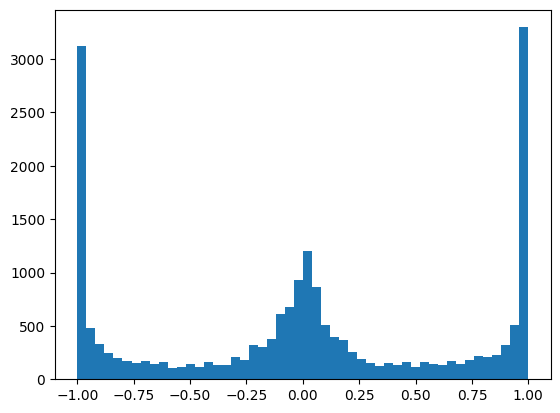

In [498]:
# Studying the hidden layer's Activation values' distribution
# Aim: To detect possibility of Dead Neurons
plt.hist(h.view(-1).tolist(), 50);

In [510]:
x = 5/(3*(CONTEXT_LEN*FEATURE_DIM)**0.5)
x

0.3042903097250923

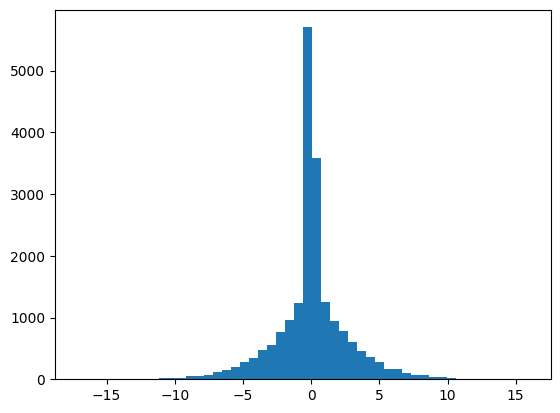

In [499]:
# Studying the hidden layer's pre-activation values' distribution
# Aim: To detect possibility of Dead Neurons
plt.hist(hpreact.view(-1).tolist(), 50);

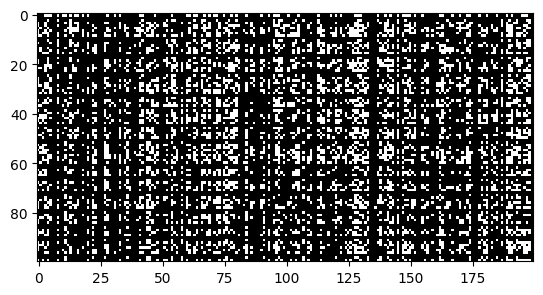

In [500]:
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation="nearest")

In [506]:
nlls

[0.5179407596588135,
 0.5173892378807068,
 0.516613781452179,
 0.5154077410697937,
 0.5151863098144531,
 0.5147512555122375,
 0.5127630233764648,
 0.5140700340270996,
 0.5130575299263,
 0.5113190412521362,
 0.5126718878746033,
 0.5098804831504822,
 0.5098053216934204,
 0.5101189613342285,
 0.5068842768669128,
 0.5071331858634949,
 0.5076448321342468,
 0.5054979920387268,
 0.5027607679367065,
 0.506802499294281,
 0.504687488079071,
 0.505776584148407,
 0.5020771026611328,
 0.5027925372123718,
 0.504957377910614,
 0.4996984899044037,
 0.4937337636947632,
 0.496453195810318,
 0.4976445138454437,
 0.4908776879310608,
 0.4929128885269165,
 0.49083441495895386,
 0.4975528419017792,
 0.4925520420074463,
 0.4797166883945465,
 0.4814424216747284,
 0.4784274995326996,
 0.47753870487213135,
 0.4677184820175171,
 0.48291078209877014,
 0.4656014144420624,
 0.4899462163448334,
 0.4804159998893738,
 0.46996062994003296,
 0.4767874777317047,
 0.47281816601753235,
 0.46517214179039,
 0.4797535240650177

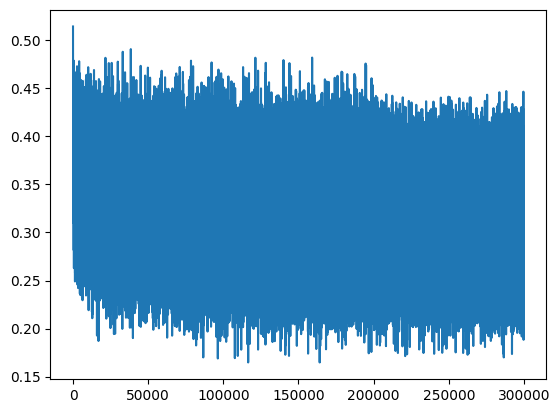

In [511]:
plt.plot(stepi, nlls)

In [512]:
xDev, yDev = torch.tensor(X[1]), torch.tensor(Y[1])

emb = C[xDev, :]
embCat = emb.view(-1, CONTEXT_LEN*FEATURE_DIM)

# Forward-Pass
h = (embCat @ W1 + B1).tanh() # Feed to Hidden Layer 1 
logits = h @ W2 + B2 # Feed to Softmax layer
loss = F.cross_entropy(logits, yDev)
loss

tensor(2.0115, grad_fn=<NllLossBackward0>)

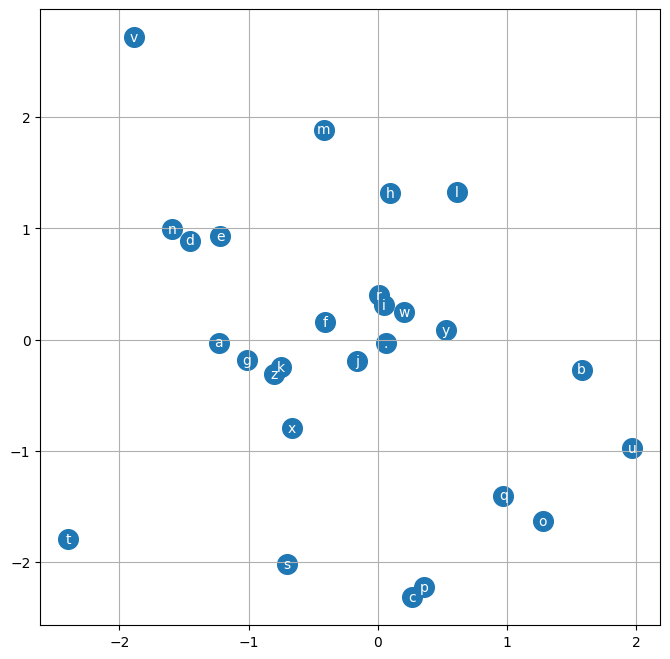

In [378]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

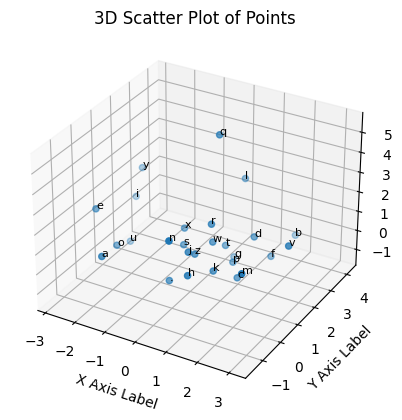

In [355]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x_values = [C[i][0].item() for i in range(C.shape[0])]
y_values = [C[i][1].item() for i in range(C.shape[0])]
z_values = [C[i][2].item() for i in range(C.shape[0])]
labels = [ch for ch, i in stoi.items()]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_values, y_values, z_values)

ax.set_xlabel('X Axis Label')
ax.set_ylabel('Y Axis Label')
ax.set_zlabel('Z Axis Label')
for x, y, z, label in zip(x_values, y_values, z_values, labels):
    ax.text(x, y, z, label, fontsize=8)

ax.set_title('3D Scatter Plot of Points')
plt.show()

In [513]:
# Sampling

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * CONTEXT_LEN # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + B1)
      logits = h @ W2 + B2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmaizabelle.
khy.
mili.
taty.
skanden.
jazziel.
deliah.
jareen.
nellara.
chaiir.
kaleigh.
ham.
joce.
quinthorline.
liveni.
wavero.
dearynix.
kael.
durden.
dae.
